# <font color='brown'>Setup </font>

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def get_current_folder():
    return os.getcwd().split("\\")[-1]

In [3]:
path = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\rounds\\'
df = pd.read_csv('{}combined_csv.csv'.format(path))

In [ ]:
df.head()

In [4]:
df = df[["ATK_wealth", "DEF_wealth", "ATK_alive", "DEF_alive", "DEF_has_OP", "Def_has_Odin",
         "RegularTime", "SpikeTime", "MapName", "FinalWinner"]]
df = pd.get_dummies(df, columns=['MapName'])

In [5]:
X = df.drop(['FinalWinner'], axis='columns')
Y = df.FinalWinner
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=15)

In [6]:
%%time
params = pd.read_csv('model_params.csv', index_col=False)
params = params.to_dict('records')[0]
params

Wall time: 3.99 ms


{'bagging_freq': 4,
 'min_data_in_leaf': 79,
 'max_depth': 12,
 'learning_rate': 0.0973296606794155,
 'num_leaves': 66,
 'num_threads': 7,
 'min_sum_hessian_in_leaf': 8}

In [7]:
model = lightgbm.LGBMClassifier(bagging_freq=params["bagging_freq"], min_data_in_leaf=params["min_data_in_leaf"],
                                max_depth=params["max_depth"],
                                learning_rate=params["learning_rate"], num_leaves=params["num_leaves"],
                                num_threads=params["num_threads"], min_sum_hessian_in_leaf=params["min_sum_hessian_in_leaf"])
model.fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=79, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=79
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=8, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=8
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


LGBMClassifier(bagging_freq=4, learning_rate=0.0973296606794155, max_depth=12,
               min_data_in_leaf=79, min_sum_hessian_in_leaf=8, num_leaves=66,
               num_threads=7)

# <font color='brown'>Dataframe </font>

In [8]:
match = 26426
series = 13189

In [9]:
import os
from webscrapping.series_scrap import RIBScrapper
from webscrapping.analyse_json import Analyser
rb = RIBScrapper()
existing_file = rb.existing_file("{}.csv".format(match))

if not existing_file:
    download_link = rb.generate_single_link(series, match)
    rb.export_json(download_link)
    
    a = Analyser("{}.json".format(match))
    matchframe = a.export_df(match)
    matchframe.to_csv(r'matches\exports\{}.csv'.format(match), index=False)

In [10]:
path2 = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\exports\\'
df = pd.read_csv('{}{}.csv'.format(path2,match))

In [11]:
df.head()

RoundID  RoundNumber  RoundTime  ATK_wealth  DEF_wealth  ATK_alive  \
0   414364            1          0       400.0       400.0          5   
1   414364            1       5830       300.0       400.0          4   
2   414364            1      16279       300.0       300.0          4   
3   414364            1      17733       300.0       200.0          4   
4   414364            1      30605       300.0       200.0          4   

   DEF_alive  DEF_has_OP  Def_has_Odin  RegularTime  SpikeTime MapName  \
0          5           0             0            0          0  Ascent   
1          5           0             0            6          0  Ascent   
2          4           0             0           16          0  Ascent   
3          3           0             0           18          0  Ascent   
4          2           0             0           31          0  Ascent   

   MatchID  SeriesID  bestOF  FinalWinner  
0    26426     13189       3            1  
1    26426     13189       3            1  
2    26426     13189       3            1  
3    26426     13189       3            1  
4    26426     13189       3            1

In [12]:
class RoundReplay:
    def __init__(self, match_id: int):
        self.match_id = match_id
        self.query = df.query('MatchID == {}'.format(match_id))
        self.round_table = self.get_round_table()
        
    def get_round_table(self) -> dict:
        g = self.query[["RoundNumber", "RoundID"]]
        g.drop_duplicates()
        return dict(zip(g.RoundNumber, g.RoundID))
    
    def get_round_id(self, round_index: int) -> int:
        return self.round_table[round_index]
    
    def get_round_dataframe(self, round_index: int):
        return df.query('RoundID == {}'.format(self.get_round_id(round_index)))
    
    def get_plant_stamp(self, round_number: int) -> int or None:
        rdf = self.get_round_dataframe(round_number)
        if max(rdf.SpikeTime) == 0:
            return None
        for i in rdf.iterrows():
            current_index = i[0]
            current_time = i[1].RegularTime
            next_time = tuple(rdf["RegularTime"].loc[[current_index + 1]])[0]
            if current_time != 0 and next_time == 0:
                return round(tuple(rdf["RoundTime"].loc[[current_index]])[0] / 1000, 0)
        return None
    
    def get_round_probability(self, round_number: int, **kwargs):
        old_table = self.get_round_dataframe(round_number)
        table = old_table[["ATK_wealth", "DEF_wealth", "ATK_alive", "DEF_alive",
                           "DEF_has_OP", "Def_has_Odin",
                           "RegularTime", "SpikeTime", "MapName"]]
        current_map = table.MapName.max()
        map_names = ["Ascent", "Bind", "Breeze", "Haven", "Icebox", "Split"]
        map_names.remove(current_map)
        table = pd.get_dummies(table, columns=['MapName'])
        for item in map_names:
            table['MapName_{}'.format(item)] = 0
        side = kwargs["side"]
        if side == "atk":
            attack_pred = [round(i[1] * 100, 2) for i in model.predict_proba(table)]
        elif side == "def":
            attack_pred = [100-round(i[1] * 100, 2) for i in model.predict_proba(table)]
        table["Attack_win_probability"] = attack_pred
        raw_timings = [int(round(x / 1000, 0)) for x in old_table.RoundTime]
        table["Round time"] = raw_timings
        return table[["Round time", "Attack_win_probability"]]
        
    def plot_round(self, round_number: int, **kwargs):
        plt.figure(figsize = (12,5))
        chosen_side=kwargs["side"]
        color_dict = {"atk": "red", "def": "blue"}
        round_data = self.get_round_probability(round_number, side=chosen_side)

        sns.set_context(rc = {'patch.linewidth': 2.0})
        sns.set(font_scale=1.3)
        ax = sns.lineplot(x="Round time", y="Attack_win_probability", data=round_data,
                          linewidth=2.0, zorder=3, color=color_dict[chosen_side])
        ax.set(xlabel='Round time (s)', ylabel='Win probability (%)')
        ax.xaxis.labelpad = 10
        ax.yaxis.labelpad = 12
        ax.grid(linewidth=.4, color='gray', zorder=0)
        title_dict = {"atk": "Attack", "def": "Defense"}
        plt.title("{} win probability over time".format(title_dict[chosen_side]))
        ax.lines[0].set_marker("o")
        ax.lines[0].set_markersize(9)
        plt.axhline(y=0, color="black")
        plt.axhline(y=50, linestyle="--", color="grey")
        plant = self.get_plant_stamp(round_number)
        if plant is not None:
            plt.axvline(x=plant)
            
        arrow = {'facecolor': 'tab:blue', 'shrink': 0.05, 'alpha': 0.75}
        plt.gca().annotate('nzr 2 frenzy kills', xy=(5.5, 61), xytext=(-8, 70), arrowprops=arrow, fontsize=13, color='green', weight='bold')
        plt.gca().annotate('khalil stinger kill', xy=(16.8, 91), xytext=(-1, 90), arrowprops=arrow, fontsize=13, color='green', weight='bold')
        plt.gca().annotate('zaks deleta o xand, \nmas o round já estava encaminhado', xy=(24, 79), xytext=(16, 60), arrowprops=arrow, fontsize=13, color='red', weight='bold')
        plt.gca().annotate('FURIA only has 20% chance \n of winning this round', xy=(0, 17), xytext=(10, 5), arrowprops=arrow, fontsize=13, color='red', weight='bold')

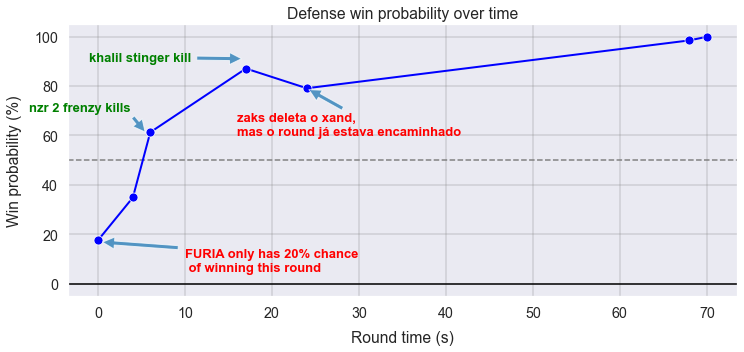

In [13]:
rr = RoundReplay(match)
rr.plot_round(7, side="def")

In [14]:
rr.get_round_probability(7, side="def")

Round time  Attack_win_probability
52           0                   17.66
53           4                   34.92
54           6                   61.28
55          17                   87.05
56          24                   79.08
57          68                   98.43
58          70                   99.89

In [15]:
rr.get_round_table()

{1: 414364,
 2: 414365,
 3: 414366,
 4: 414367,
 5: 414368,
 6: 414369,
 7: 414370,
 8: 414371,
 9: 414372,
 10: 414373,
 11: 414374,
 12: 414375,
 13: 414376,
 14: 414377,
 15: 414378,
 16: 414379,
 17: 414380,
 18: 414381,
 19: 414382,
 20: 414383,
 21: 414384,
 22: 414385}

In [16]:
x = {15: 'Astra',
     1: 'Breach',
     8: 'Brimstone',
     3: 'Cypher',
     4: 'Jett',
     5: 'Killjoy',
     11: 'Omen',
     7: 'Phoenix',
     2: 'Raze',
     10: 'Reyna',
     9: 'Sage',
     13: 'Skye',
     4: 'Sova',
     6: 'Viper',
     14: 'Yoru'}
{key: value for key, value in sorted(x.items(), key=lambda item: item[0])}

{1: 'Breach',
 2: 'Raze',
 3: 'Cypher',
 4: 'Sova',
 5: 'Killjoy',
 6: 'Viper',
 7: 'Phoenix',
 8: 'Brimstone',
 9: 'Sage',
 10: 'Reyna',
 11: 'Omen',
 13: 'Skye',
 14: 'Yoru',
 15: 'Astra'}

https://runitback.gg/series/12745?match=25645&round=19&tab=replay